#  Meeting Matrices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import nafot
from tqdm import tqdm, tqdm_notebook
import pickle
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'impala'

## Load raw matrix

In [5]:
gdf = nafot.gdf.copy()

In [6]:
#### Matrix A ####
gdf = nafot.gdf.copy()
matrix_A = np.load('../data/matrix/visit_matrix_raw_all.npy')

# Save to a dataframe
area = 'stat_area'
areas_ids = np.array(gdf.index.values)
matrix_A_df = pd.DataFrame(matrix_A, index=areas_ids, columns=areas_ids)

## Statistical area level

### Population size - by stat area

Number of areas with population > 0: 1502 (out of 3070)

	Areas with population < 5: 243 areas, 482 users (0.30%)    (1259 areas remaining)
	Areas with population < 10: 336 areas, 1,110 users (0.69%)    (1166 areas remaining)
	Areas with population < 20: 448 areas, 2,771 users (1.71%)    (1054 areas remaining)
	Areas with population < 30: 538 areas, 4,982 users (3.08%)    (964 areas remaining)
	Areas with population < 50: 688 areas, 10,972 users (6.79%)    (814 areas remaining)


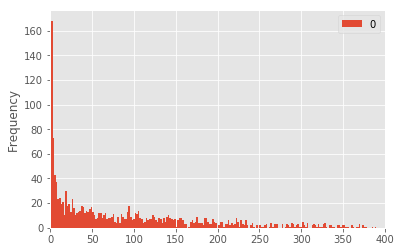

In [4]:
population_sizes = matrix_A_df.sum(1)[matrix_A_df.sum(1) > 0]
print(f'Number of areas with population > 0: {population_sizes.size} (out of {matrix_A_df.index.size})\n')
for i in [5,10,20,30,50]:
    curr_pop = population_sizes[population_sizes<i]
    print(f'\tAreas with population < {i}: {curr_pop.size} areas, {int(curr_pop.sum()):,d} users ({curr_pop.sum()/(matrix_A_df.sum(1).sum())*100:.2f}%)\
    ({population_sizes.size - curr_pop.size} areas remaining)')

# Plot popoulation sizes
pd.DataFrame(population_sizes).plot.hist(bins=1502)
plt.xlim([0,400])
plt.show()

### Removing irrelevant areas

In [2]:
# Get the list of irrelevant stat ares (from Hasharon, Be'er Sheva and Hadera subdistricts)
subdist_stat_area_hierarchy = nafot.get_hierarchical_list('subdistrict')
irrelevant_areas = np.array([], dtype='int64')
for subdist in [32,41,62]:
    irrelevant_areas = np.append(irrelevant_areas, subdist_stat_area_hierarchy[subdist])
    
# Remove those areas from the raw matrix
matrix_A_df.loc[irrelevant_areas] = 0
matrix_A_df.loc[:,irrelevant_areas] = 0

### Population size - by stat area - after removing irrelevant areas

Number of areas with population > 0: 1411 (out of 3070) ; population: 159,693 users

	Areas with population < 5: 217 areas, 477 users (0.30%)    (1194 areas remaining)
	Areas with population < 10: 290 areas, 1,017 users (0.64%)    (1121 areas remaining)
	Areas with population < 20: 390 areas, 2,577 users (1.61%)    (1021 areas remaining)
	Areas with population < 30: 466 areas, 4,510 users (2.82%)    (945 areas remaining)
	Areas with population < 50: 606 areas, 10,202 users (6.39%)    (805 areas remaining)


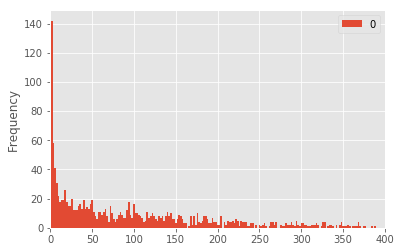

In [6]:
population_sizes = matrix_A_df.sum(1)[matrix_A_df.sum(1) > 0]
print(f'Number of areas with population > 0: {population_sizes.size} (out of {matrix_A_df.index.size}) ; \
population: {int(population_sizes.sum()):,d} users\n')
for i in [5,10,20,30,50]:
    curr_pop = population_sizes[population_sizes<i]
    print(f'\tAreas with population < {i}: {curr_pop.size} areas, {int(curr_pop.sum()):,d} users ({curr_pop.sum()/(matrix_A_df.sum(1).sum())*100:.2f}%)\
    ({population_sizes.size - curr_pop.size} areas remaining)')

# Plot popoulation sizes
pd.DataFrame(population_sizes).plot.hist(bins=1411)
plt.xlim([0,400])
plt.show()

### Calculate the contact matrix

In [ ]:
contact_matrix_stat_area_df = nafot.visits_to_contact_matrix(matrix_A, 'stat_area')

# Save the final matrix
# contact_matrix_stat_area_df.to_csv('../data/matrix/contact_matrix_final_sample.csv')

### Final matrix - Creating Heatmap

#### Log Transforamtion

In [7]:
meeting_mat_log_df = contact_matrix_stat_area_df.applymap(lambda x: np.log(25*x))

NameError: name 'contact_matrix_stat_area_df' is not defined

In [8]:
# fig, ax = plt.subplots(figsize=(180,140))
# ax.set_title("Contact Heat Map")
# heat = sns.heatmap(meeting_mat_log_df, ax=ax, cmap='YlOrRd', robust = True)

# # Color bar
# cb = fig.axes[1]
# ticks = np.array([0.15,0.30,0.45,0.60,0.75]) 
# cb.set_yticklabels(ticks)

# plt.savefig('../img/contact_heatmap_log_final_sample.png', bbox_inches="tight")
# plt.show()

## Yeshuv level

### Aggregate by yeshuv

In [7]:
# Get relevant level codes and names
area_level = 'yeshuv'
hierarchical_list = nafot.get_hierarchical_list(area_level)

# Get codes column names in gdf
code_col_names = {'district': 'DistrictCode', 'subdistrict': 'SubDistrictCode', 'yeshuv': 'SEMEL_YISH'}

if area_level != 'stat_area':
    # If the level is not stat area, add the relevant level to the location data
    area_col = code_col_names[area_level] 

# Get a list of the area's ids
areas_ids = pd.unique(gdf[area_col])

# Remove NaN
areas_ids = np.array(areas_ids[~np.isnan(areas_ids)])

# Aggregate the columns
matrix_A_agg_cols_df = pd.DataFrame(index=matrix_A_df.index, columns=areas_ids)
for agg_area_id in tqdm(areas_ids, 'Columns'):
    matrix_A_agg_cols_df[agg_area_id] = matrix_A_df[hierarchical_list[agg_area_id]].sum(axis=1)
    
# Aggregate the rows
matrix_A_yeshuv_df = pd.DataFrame(index=areas_ids, columns=areas_ids)
for agg_area_id in tqdm(areas_ids, 'Rows'):
    matrix_A_yeshuv_df.loc[agg_area_id] = matrix_A_agg_cols_df.loc[hierarchical_list[agg_area_id]].sum()

Rows: 100%|████████████████████████████████████████████████████████████████████████| 1235/1235 [00:58<00:00, 21.13it/s]


In [8]:
matrix_A_yeshuv_df.sum(1)

7          38.0
10          5.0
11         19.0
13          0.0
15         26.0
16         12.0
18         60.0
21          0.0
22         38.0
23          2.0
24         23.0
26          0.0
27          1.0
28        228.0
29          0.0
31          0.0
32         33.0
33          0.0
35          0.0
36          7.0
37         45.0
39         12.0
41          0.0
43          0.0
44         12.0
46          0.0
47          0.0
48          0.0
49          0.0
52          1.0
          ...  
10014       0.0
10015       0.0
10016       1.0
10018       4.0
10020     320.0
10025    2057.0
10026    2936.0
10029     147.0
10030     100.0
10031       9.0
10032       1.0
10033     491.0
10034     249.0
10035     391.0
10036      48.0
10037      38.0
10038       2.0
10039       4.0
10040     446.0
10041      35.0
10042      33.0
10048       0.0
10050     527.0
10051       0.0
10052       0.0
10053       0.0
10054       0.0
10055       0.0
10056       0.0
10071       0.0
Length: 1235, dtype: flo

### Population size - by stat yeshuv

Number of areas with population > 0: 368 (out of 1235)

	Areas with population < 5: 55 areas, 119 users (0.07%)    (313 areas remaining)
	Areas with population < 10: 78 areas, 296 users (0.19%)    (290 areas remaining)
	Areas with population < 20: 128 areas, 1,070 users (0.67%)    (240 areas remaining)
	Areas with population < 30: 159 areas, 1,865 users (1.17%)    (209 areas remaining)
	Areas with population < 50: 214 areas, 3,979 users (2.49%)    (154 areas remaining)
	Areas with population < 100: 270 areas, 8,075 users (5.06%)    (98 areas remaining)


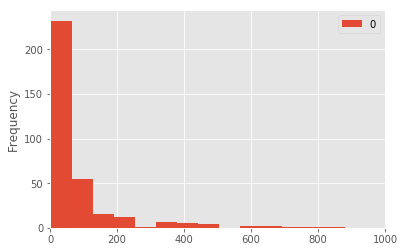

In [10]:
population_sizes_yeshuv = matrix_A_yeshuv_df.sum(1)[matrix_A_yeshuv_df.sum(1) > 0]
print(f'Number of areas with population > 0: {population_sizes_yeshuv.size} (out of {matrix_A_yeshuv_df.index.size})\n')
for i in [5,10,20,30,50,100]:
    curr_pop = population_sizes_yeshuv[population_sizes_yeshuv<i]
    print(f'\tAreas with population < {i}: {curr_pop.size} areas, {int(curr_pop.sum()):,d} users ({curr_pop.sum()/(matrix_A_df.sum(1).sum())*100:.2f}%)\
    ({population_sizes_yeshuv.size - curr_pop.size} areas remaining)')

# Plot popoulation sizes
pd.DataFrame(population_sizes_yeshuv).plot.hist(bins=432)
plt.xlim([0,1000])
plt.show()

### Calculate contact matrix

In [11]:
# Matrix A
visits_matrix_yeshuv = matrix_A_yeshuv_df.values

# Calculate contact matrix
contact_matrix_yeshuv = nafot.visits_to_contact_matrix(visits_matrix_yeshuv, 'yeshuv')

# Save the final matrix
contact_matrix_yeshuv.to_csv('../data/matrix/contact_matrix_final_sample_yeshuv.csv')

Number of areas without population data (not home stat area): 530
Number of areas without population data (home stat area): 120


100%|██████████| 705/705 [00:33<00:00, 21.36it/s]


## Subdistrict level

### Aggregate by subdist

In [8]:
# Get relevant level codes and names
area_level = 'subdistrict'
hierarchical_list = nafot.get_hierarchical_list(area_level)

# Get codes column names in gdf
code_col_names = {'district': 'DistrictCode', 'subdistrict': 'SubDistrictCode', 'yeshuv': 'SEMEL_YISH'}

if area_level != 'stat_area':
    # If the level is not stat area, add the relevant level to the location data
    area_col = code_col_names[area_level] 

# Get a list of the area's ids
areas_ids = pd.unique(gdf[area_col])

# Remove NaN
areas_ids = np.array(areas_ids[~np.isnan(areas_ids)])

# Aggregate the columns
matrix_A_agg_cols_df = pd.DataFrame(index=matrix_A_df.index, columns=areas_ids)
for agg_area_id in areas_ids:
    matrix_A_agg_cols_df[agg_area_id] = matrix_A_df[hierarchical_list[agg_area_id]].sum(axis=1)

# Aggregate the rows
matrix_A_subdist_df = pd.DataFrame(index=areas_ids, columns=areas_ids)
for agg_area_id in areas_ids:
    matrix_A_subdist_df.loc[agg_area_id] = matrix_A_agg_cols_df.loc[hierarchical_list[agg_area_id]].sum()

In [11]:
matrix_A_subdist_df.sum(1)

61.0     8703.730677
11.0    20252.536305
62.0        0.000000
51.0    64477.927725
21.0        0.000000
44.0     5603.201805
32.0        0.000000
41.0        0.000000
22.0        0.000000
43.0    15299.265429
23.0        0.000000
31.0        0.000000
42.0    40633.829994
24.0        0.000000
77.0     4723.403773
29.0        0.000000
dtype: float64

### Population size - by subdistrict

In [13]:
# Population size
matrix_A_subdist_df.sum(1).sort_values()

62.0        0.000000
21.0        0.000000
32.0        0.000000
41.0        0.000000
22.0        0.000000
23.0        0.000000
31.0        0.000000
24.0        0.000000
29.0        0.000000
77.0     4723.403773
44.0     5603.201805
61.0     8703.730677
43.0    15299.265429
11.0    20252.536305
42.0    40633.829994
51.0    64477.927725
dtype: float64

### Calculate contact matrix

In [14]:
# Matrix A
visits_matrix_subdist = matrix_A_subdist_df.values

# Calculate contact matrix
contact_matrix_subdist = nafot.visits_to_contact_matrix(visits_matrix_subdist, 'subdistrict')

# Save the final matrix
contact_matrix_subdist.to_csv('../data/matrix/contact_matrix_final_sample_subdist.csv')

Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0


100%|██████████| 16/16 [00:00<00:00, 3215.72it/s]


## Sparse areas

In [15]:
# Get stat areas with less than 30 users
sparse_areas = population_sizes[population_sizes < 30].index

# Get sparse yeshuvim
sparse_yeshuvim = population_sizes_yeshuv[population_sizes_yeshuv < 30].index

# Get sparse stat areas' yesuv 
sparse_areas_yeshuv = [gdf.loc[area]['SEMEL_YISH'] for area in sparse_areas]

# Get sparse stat areas' subdistrict 
sparse_areas_subdist = [gdf.loc[area]['SubDistrictCode'] for area in sparse_areas]

Use higher hirarchy instead of the sparse areas

In [18]:
# initialize a dictionary
sparse_area_dict = {}

# Go over the sparse areas
for i, area in enumerate(sparse_areas):
    # If the stat area's yeshuv is also sparse, use the subdistrict
    if sparse_areas_yeshuv[i] in sparse_yeshuvim:
        sparse_area_dict[area] = ['subdistrict', sparse_areas_subdist[i]]
    # If the stat area's yeshuv is not sparse, use it
    else:
        sparse_area_dict[area] = ['yeshuv', sparse_areas_yeshuv[i]]
        
# Saving the dict
with open('../data/sparse_areas.pickle','wb') as pickle_out:
    pickle.dump(sparse_area_dict, pickle_out)

# Loading the dict
# with open('../data/sparse_areas.pickle','rb') as pickle_in:
#     sparse_ares_dict = pickle.load(pickle_in)

# Updated till here

# Religion Contact Matrix

#### Aggregate the columns

In [24]:
religions = list(nafot.religion_dict.values())

In [25]:
religion_agg_cols_df = pd.DataFrame(index=matrix_A_df.index, columns=religions)

for rel in religions:
    religion_agg_cols_df[rel] = matrix_A_df[gdf[gdf.religion == rel].index.values].sum(axis=1)

#### Aggregate the rows

In [26]:
religion_agg_df = pd.DataFrame(index=religions, columns=religions)

for rel in religions:
    religion_agg_df.loc[rel] = religion_agg_cols_df.loc[gdf[gdf.religion == rel].index.values].sum()

In [27]:
# Save the final matrix
meeting_matrix_subdist.to_csv('../data/matrix/sample1+2_final_matrix_.csv')        

In [28]:
#### Matrix A ####
visits_matrix_religion = religion_agg_df.values

contat_mat_religion = vists_to_contact_matrix(visits_matrix_religion, 'religion')

Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0



In [29]:
# Save the final matrix
# meeting_matrix_subdist.to_csv('../data/matrix/sample1+2_final_matrix_religion.csv')        

In [30]:
contat_mat_religion_log_df = contat_mat_religion.applymap(lambda x: np.log(25*x))

## Religion matrix - Creating Heatmap

In [31]:
contat_mat_religion

,Jewish,Muslim
Jewish,0.891640,0.039986
Muslim,0.370733,0.322009


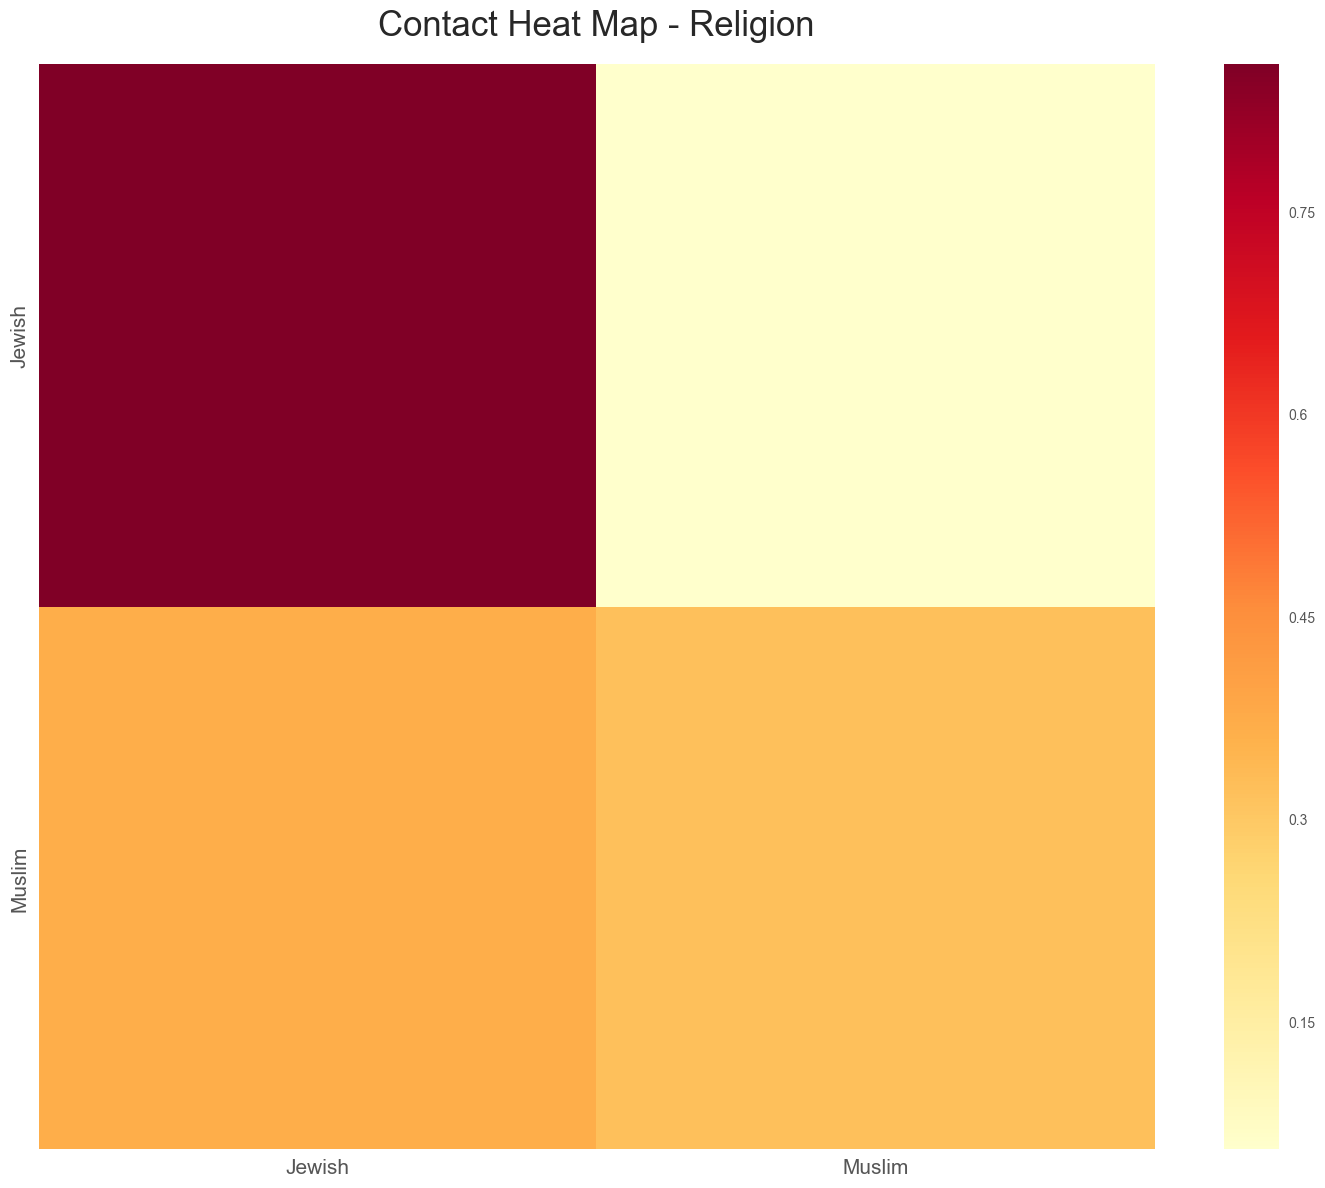

In [32]:
fig, ax = plt.subplots(figsize=(18,14))
ax.set_title("Contact Heat Map - Religion", {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(contat_mat_religion, ax=ax, cmap='YlOrRd', robust = True)
ax.tick_params(labelsize=15)

# Color bar
cb = fig.axes[1]
ticks = np.array([0.15,0.30,0.45,0.60,0.75]) 
cb.set_yticklabels(ticks)

# plt.savefig('../img/contact_heatmap_religion_sample1+2.png', bbox_inches="tight")
plt.show()

# Religion with Orthodox Contact Matrix

#### Aggregate the columns

In [33]:
rels_with_ort = religion_with_orthodox.columns[:-1]
# Get only relevant areas in matrix A (only area with religion data)
matrix_A_df_rel = matrix_A_df.loc[religion_with_orthodox.index.values][religion_with_orthodox.index.values].copy()

In [34]:
rel_agg_cols_df = pd.DataFrame(index=matrix_A_df_rel.index, columns=rels_with_ort)
for rel in rels_with_ort:
    rel_agg_cols_df[rel] = matrix_A_df_rel.multiply(religion_with_orthodox[rel], axis='columns').sum(axis=1)

#### Aggregate the rows

In [35]:
rel_agg_df = pd.DataFrame(index=rels_with_ort, columns=rels_with_ort)
for rel in rels_with_ort:
    rel_agg_df.loc[rel] = rel_agg_cols_df.multiply(religion_with_orthodox[rel], axis='rows').sum()

In [36]:
rel_agg_df

,Jewish Orthodox,Jewish Non-Orthodox,Muslim,Christian,Druze,Other
Jewish Orthodox,168.6,183.116,4.00156,0,0,0
Jewish Non-Orthodox,192.056,2652.35,53.2525,0,0,0
Muslim,2.57879,36.6808,131.034,0,0,0
Christian,0,0,0,0,0,0
Druze,0,0,0,0,0,0
Other,0,0,0,0,0,0


In [37]:
contat_mat_rel = vists_to_contact_matrix(rel_agg_df.values, 'religion_with_orthodox')

Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0



In [38]:
contat_mat_rel

,Jewish Orthodox,Jewish Non-Orthodox,Muslim
Jewish Orthodox,0.134864,0.416340,0.016176
Jewish Non-Orthodox,0.051755,0.717012,0.027170
Muslim,0.012121,0.169599,0.554450


In [39]:

contat_mat_rel_norm = contat_mat_rel.values.copy() 
for i in range(contat_mat_rel_norm.shape[0]):
    if contat_mat_rel_norm[i].sum() > 0:
        contat_mat_rel_norm[i] = contat_mat_rel_norm[i] / (contat_mat_rel_norm[i].sum())
        
contat_mat_rel_norm = pd.DataFrame(contat_mat_rel_norm, index=contat_mat_rel.index, columns=contat_mat_rel.columns)
contat_mat_rel_norm

,Jewish Orthodox,Jewish Non-Orthodox,Muslim
Jewish Orthodox,0.237696,0.733794,0.028510
Jewish Non-Orthodox,0.065024,0.900840,0.034136
Muslim,0.016466,0.230380,0.753154


In [40]:
# Save the final matrix
# contat_mat_edu.to_csv('../data/matrix/sample1+2_final_matrix_religion_with_orthodox.csv')        

## Religion with Orthodox Contact Matrix - Creating Heatmap

In [41]:
contat_mat_rel_log_df = contat_mat_rel_norm.applymap(lambda x: np.log(10*x))

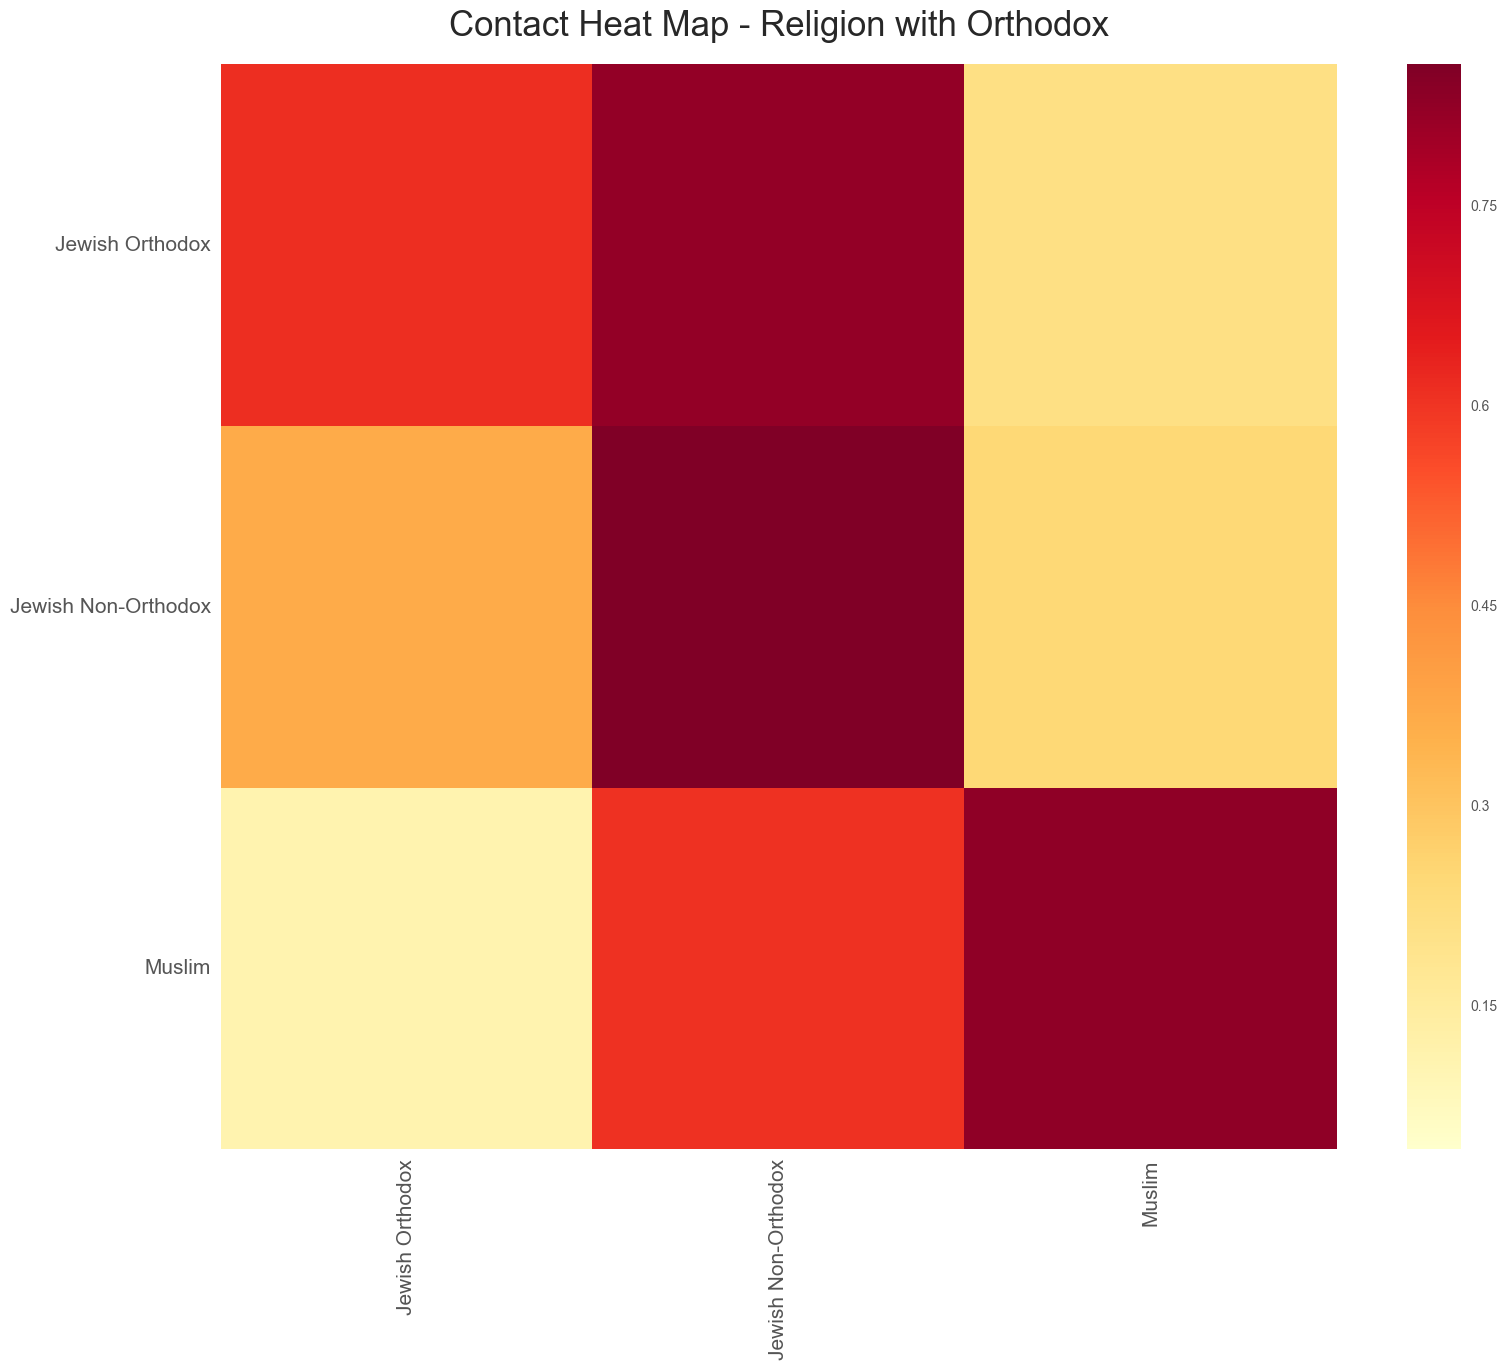

In [42]:
fig, ax = plt.subplots(figsize=(18,14))
ax.set_title("Contact Heat Map - Religion with Orthodox", {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(contat_mat_rel_log_df, ax=ax, cmap='YlOrRd', robust = True)
ax.tick_params(labelsize=15)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


# Color bar
cb = fig.axes[1]
ticks = np.array([0.15,0.30,0.45,0.60,0.75]) 
cb.set_yticklabels(ticks)

# plt.savefig('../img/contact_heatmap_religion_with_orthodox_sample1+2.png', bbox_inches="tight")
plt.show()

# Education

In [43]:
edu_levels = education.columns[:-1]

In [44]:
pop_d = {col: ((education[col]*education.pop_thou).sum()*1000) for col in edu_levels}

In [45]:
pop_d

{'Acadm1Cert_pcnt': 918694.2999999998,
 'Acadm2Cert_pcnt': 548456.3999999999,
 'MatricCert_pcnt': 1481125.9999999986,
 'OtherCertA_pcnt': 1715830.599999998,
 'PostSecondaryCert_pcnt': 802108.7999999999,
 'SecondaryCert_pcnt': 1089027.9999999995}

In [46]:
sum(pop_d.values())

6555244.099999996

#### Aggregate the columns

In [47]:
edu_levels = education.columns[:-1]
# Get only relevant areas in matrix A (only area with education data)
matrix_A_df_edu = matrix_A_df.loc[education.index.values][education.index.values].copy()

In [48]:
edu_agg_cols_df = pd.DataFrame(index=matrix_A_df_edu.index, columns=edu_levels)

for ed_lvl in edu_levels:
    edu_agg_cols_df[ed_lvl] = matrix_A_df_edu.multiply(education[ed_lvl], axis='columns').sum(axis=1)

#### Aggregate the rows

In [49]:
edu_agg_df = pd.DataFrame(index=edu_levels, columns=edu_levels)
for ed_lvl in edu_levels:
    edu_agg_df.loc[ed_lvl] = edu_agg_cols_df.multiply(education[ed_lvl], axis='rows').sum()

In [50]:
edu_agg_df

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt
SecondaryCert_pcnt,162.507,206.895,97.9315,141.402,84.4485,194.054
MatricCert_pcnt,206.994,339.654,145.575,256.736,156.853,265.722
PostSecondaryCert_pcnt,99.0855,146.89,78.9442,113.561,69.4034,131.335
Acadm1Cert_pcnt,141.315,256.595,112.544,228.272,138.363,180.595
Acadm2Cert_pcnt,84.3855,156.94,68.8423,138.434,90.3318,107.916
OtherCertA_pcnt,192.835,262.905,128.846,178.742,106.763,281.398


In [51]:
contat_mat_edu = vists_to_contact_matrix(edu_agg_df.values, 'education')

Number of areas without population data (not home stat area): 0
Number of areas without population data (home stat area): 0



In [52]:
contat_mat_edu

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt
SecondaryCert_pcnt,0.030873,0.040757,0.021800,0.024831,0.014744,0.049346
MatricCert_pcnt,0.030163,0.041173,0.021749,0.025701,0.015316,0.048034
PostSecondaryCert_pcnt,0.030091,0.040565,0.021642,0.025151,0.014972,0.048142
Acadm1Cert_pcnt,0.029379,0.041084,0.021552,0.026204,0.015655,0.046552
Acadm2Cert_pcnt,0.029197,0.040981,0.021474,0.026205,0.015677,0.046229
OtherCertA_pcnt,0.031011,0.040794,0.021917,0.024735,0.014676,0.050116


In [53]:
# Save the final matrix
contat_mat_edu.to_csv('../data/matrix/sample1+2_final_matrix_education.csv')        

## Education Contact Matrix - Creating Heatmap

In [54]:
contat_mat_edu_log_df = contat_mat_edu.applymap(lambda x: np.log(25*x))

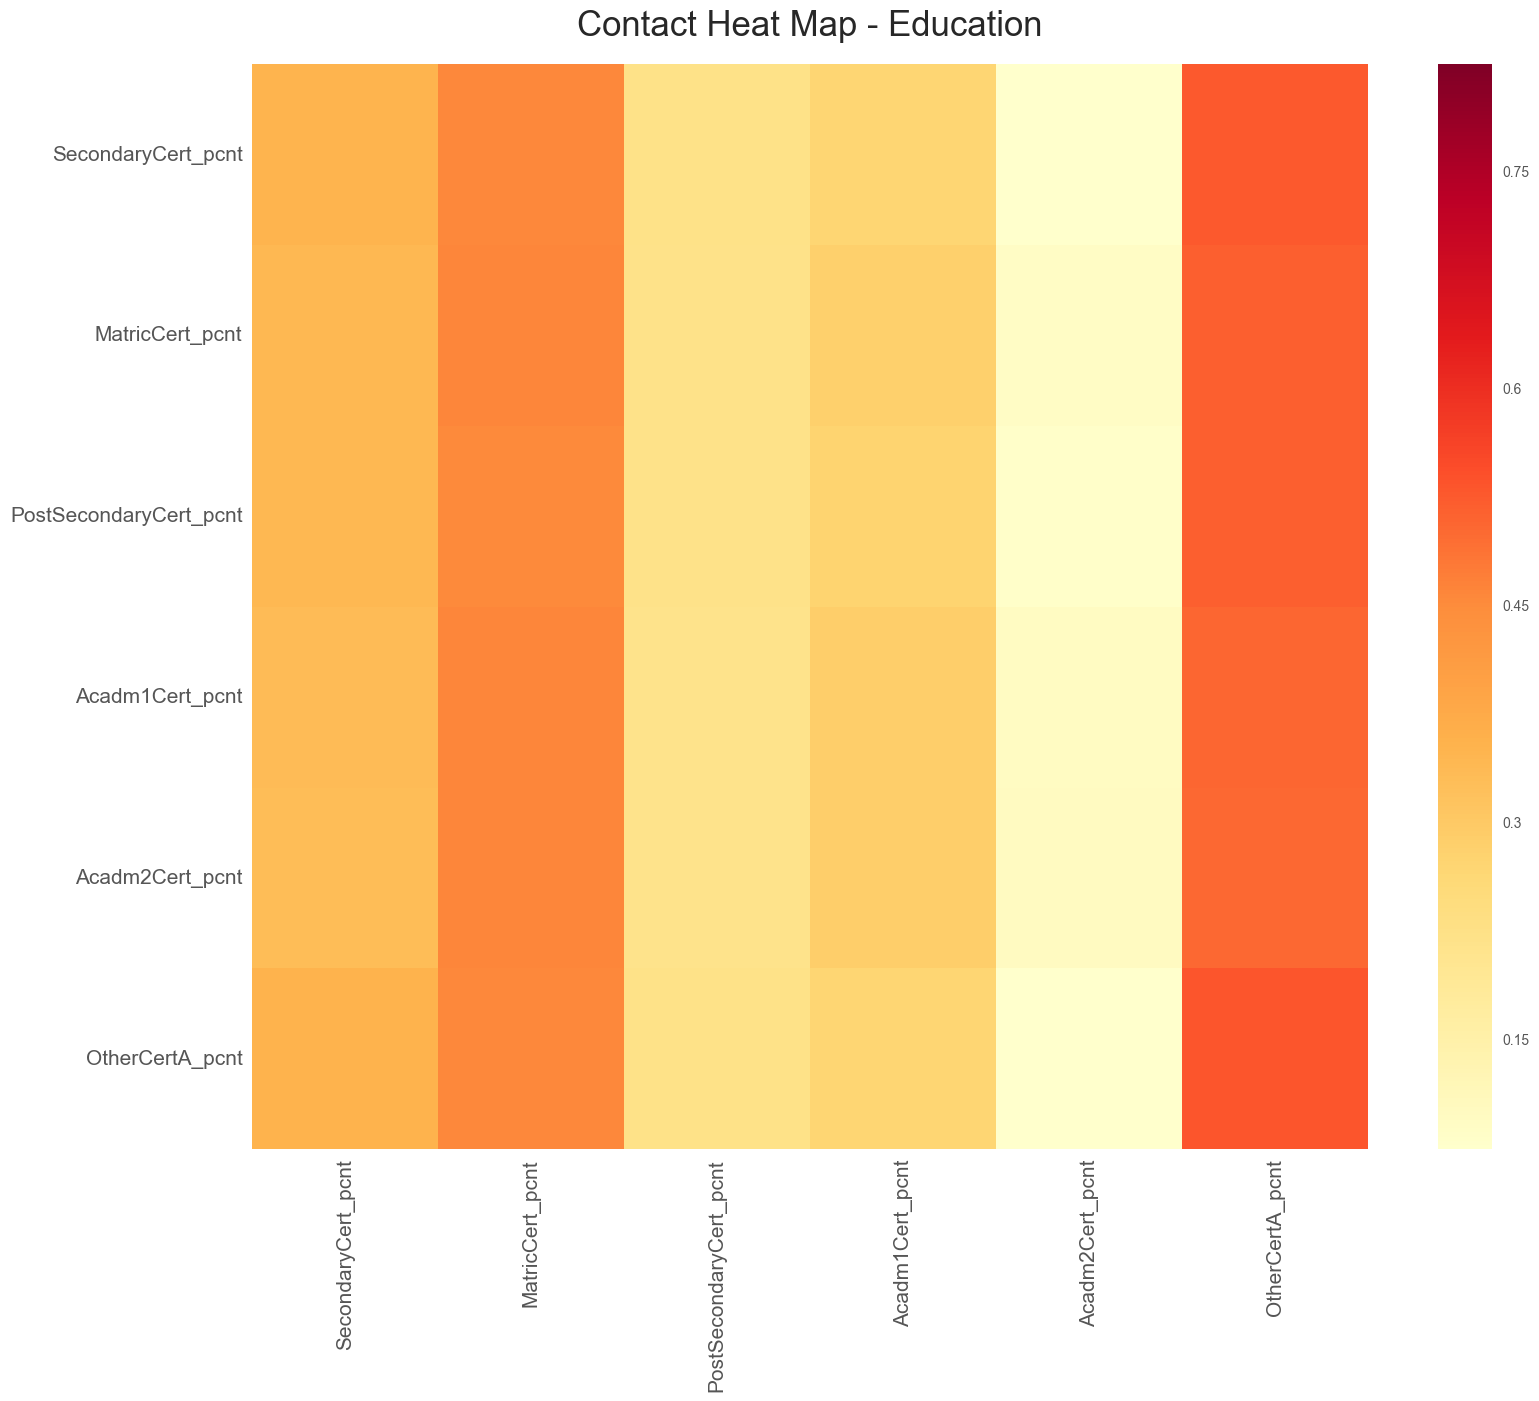

In [55]:
fig, ax = plt.subplots(figsize=(18,14))
ax.set_title("Contact Heat Map - Education", {'fontsize': 25, 'position': (0.5,1.02)})
heat = sns.heatmap(contat_mat_edu_log_df, ax=ax, cmap='YlOrRd', robust = True)
ax.tick_params(labelsize=15)
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


# Color bar
cb = fig.axes[1]
ticks = np.array([0.15,0.30,0.45,0.60,0.75]) 
cb.set_yticklabels(ticks)

# plt.savefig('../img/contact_heatmap_education_sample1+2.png', bbox_inches="tight")
plt.show()

In [56]:
contat_mat_edu_norm = contat_mat_edu.values.copy() 
for i in range(contat_mat_edu_norm.shape[0]):
    if contat_mat_edu_norm[i].sum() > 0:
        contat_mat_edu_norm[i] = contat_mat_edu_norm[i] / (contat_mat_edu_norm[i].sum())
        
contat_mat_edu_norm = pd.DataFrame(contat_mat_edu_norm, index=contat_mat_edu.index, columns=contat_mat_edu.columns)

In [57]:
contat_mat_edu_norm

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt
SecondaryCert_pcnt,0.169304,0.223510,0.119551,0.136173,0.080854,0.270608
MatricCert_pcnt,0.165605,0.226057,0.119410,0.141111,0.084090,0.263726
PostSecondaryCert_pcnt,0.166649,0.224659,0.119859,0.139293,0.082920,0.266620
Acadm1Cert_pcnt,0.162829,0.227707,0.119450,0.145233,0.086769,0.258012
Acadm2Cert_pcnt,0.162418,0.227974,0.119456,0.145777,0.087207,0.257168
OtherCertA_pcnt,0.169228,0.222614,0.119603,0.134978,0.080089,0.273488


In [58]:
mat_pop = pd.DataFrame(index=contat_mat_edu.index, columns=contat_mat_edu.columns)
for col in mat_pop.columns:
    mat_pop[col] = pop_d[col] / sum(pop_d.values())

mat_pop

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt
SecondaryCert_pcnt,0.166131,0.225945,0.122361,0.140146,0.083667,0.261749
MatricCert_pcnt,0.166131,0.225945,0.122361,0.140146,0.083667,0.261749
PostSecondaryCert_pcnt,0.166131,0.225945,0.122361,0.140146,0.083667,0.261749
Acadm1Cert_pcnt,0.166131,0.225945,0.122361,0.140146,0.083667,0.261749
Acadm2Cert_pcnt,0.166131,0.225945,0.122361,0.140146,0.083667,0.261749
OtherCertA_pcnt,0.166131,0.225945,0.122361,0.140146,0.083667,0.261749


In [59]:
devided_mat = pd.DataFrame(contat_mat_edu_norm / mat_pop, index=contat_mat_edu.index, columns=contat_mat_edu.columns)
devided_mat

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt
SecondaryCert_pcnt,1.019103,0.989222,0.977028,0.971648,0.966377,1.033845
MatricCert_pcnt,0.996837,1.000495,0.975877,1.006884,1.005063,1.007552
PostSecondaryCert_pcnt,1.003117,0.994308,0.979549,0.993913,0.991070,1.018609
Acadm1Cert_pcnt,0.980126,1.007798,0.976205,1.036292,1.037080,0.985722
Acadm2Cert_pcnt,0.977650,1.008980,0.976254,1.040175,1.042316,0.982498
OtherCertA_pcnt,1.018641,0.985257,0.977458,0.963119,0.957238,1.044848


In [60]:
pop_d

{'Acadm1Cert_pcnt': 918694.2999999998,
 'Acadm2Cert_pcnt': 548456.3999999999,
 'MatricCert_pcnt': 1481125.9999999986,
 'OtherCertA_pcnt': 1715830.599999998,
 'PostSecondaryCert_pcnt': 802108.7999999999,
 'SecondaryCert_pcnt': 1089027.9999999995}

In [61]:
education.head()

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt,pop_thou
stat_id,,,,,,,
261,0.090,0.306,0.181,0.202,0.063,0.157,2.6
281,0.138,0.234,0.116,0.194,0.141,0.177,8.9
311,0.203,0.245,0.152,0.118,0.045,0.237,4.4
312,0.252,0.197,0.121,0.058,0.021,0.351,3.1
313,0.253,0.236,0.126,0.040,0.014,0.331,3.3


In [62]:
education.describe()

,SecondaryCert_pcnt,MatricCert_pcnt,PostSecondaryCert_pcnt,Acadm1Cert_pcnt,Acadm2Cert_pcnt,OtherCertA_pcnt,pop_thou
count,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000
mean,0.166818,0.231590,0.122621,0.146170,0.090090,0.242718,3.795599
std,0.084948,0.071135,0.058810,0.081491,0.067764,0.141299,6.530312
min,0.006000,0.002000,0.002000,0.003000,0.000000,0.016000,0.600000
25%,0.107000,0.196000,0.083000,0.084000,0.032000,0.136500,2.600000
50%,0.158000,0.235000,0.114000,0.130000,0.081000,0.202000,3.500000
75%,0.211000,0.270000,0.157000,0.196000,0.125000,0.317000,4.400000
max,0.630000,0.702000,0.390000,0.425000,0.378000,0.818000,267.000000
